# Multi class image classification using Transfer learning

In [1]:
# Mount folder from google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# enabling and testing GPU
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
!pwd

/content


In [4]:
# get GPU specs on google collab
!nvidia-smi

Wed Nov 30 21:20:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    30W /  70W |    312MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
# Required packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
 
from sklearn.metrics import classification_report, confusion_matrix
 
# deep learning libraries
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from keras.preprocessing import image
 
import cv2
 
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Split  training and test/val data  
# folders path { initially data is split into 70% train and 30% val/test}
str_train_dir = "/content/drive/MyDrive/train_size_300"
str_valtest_dir = "/content/drive/MyDrive/valtest_size_300"

train_gen = ImageDataGenerator(
                  rescale = 1./255,
                  horizontal_flip = True,
                 )

train_generator = train_gen.flow_from_directory(
    directory = str_train_dir, # images data path / folder in which images are there
    subset="training",
    color_mode="rgb",
    target_size = (331,331), # image height , image width
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=42,
)
#Separate val and test from 30% val/test data to generate final [70% train, 15% val and 15% test sets]

val_test_gen =  ImageDataGenerator(
                  rescale = 1./255,
                  horizontal_flip = True,
                  validation_split = 0.5
                 )
 
validation_generator = val_test_gen.flow_from_directory(
    directory = str_valtest_dir, # images data path / folder in which val/test images are present
    subset="training",
    color_mode="rgb",
    target_size = (331,331), # image height , image width
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=42,
)
test_generator = val_test_gen.flow_from_directory(
    directory = str_valtest_dir, # images data path / folder in which val/test images are present
    subset="validation",
    color_mode="rgb",
    target_size = (331,331), # image height , image width
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=42,
)

Found 1204 images belonging to 6 classes.
Found 261 images belonging to 6 classes.
Found 258 images belonging to 6 classes.


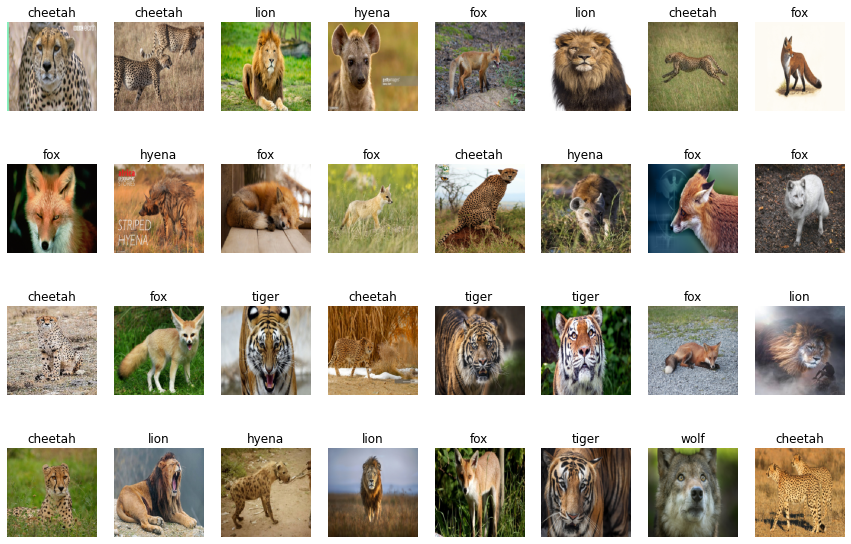

In [7]:
a = train_generator.class_indices
class_names = list(a.keys()) # storing class/breed names in a list
# Use a batch of training samples from training generator to visualize data
x,y = next(train_generator)
x.shape # input shape of one record is (331,331,3) , 32: is the batch size
# function to plot the training examples with labels
def plot_images(img, labels):
	plt.figure(figsize=[15, 10])
	for i in range(32):
		plt.subplot(4, 8, i+1)
		plt.imshow(img[i])
		plt.title(class_names[np.argmax(labels[i])])
	
		 
		plt.axis('off')
	
plot_images(x,y)


In [8]:
# load the InceptionResNetV2 architecture with imagenet weights as base
base_model = tf.keras.applications.InceptionResNetV2(
					include_top=False,
					weights='imagenet',
					input_shape=(331,331,3)
					)

base_model.trainable=False
# For freezing the layer we make use of layer.trainable = False
# means that its internal state will not change during training.
# model's trainable weights will not be updated during fit(),
# and also its state updates will not run.

model = tf.keras.Sequential([
		base_model,
		tf.keras.layers.BatchNormalization(renorm=True),
		tf.keras.layers.GlobalAveragePooling2D(),
		tf.keras.layers.Dense(512, activation='relu'),
		tf.keras.layers.Dense(256, activation='relu'),
		tf.keras.layers.Dropout(0.5),
		tf.keras.layers.Dense(128, activation='relu'),
		tf.keras.layers.Dense(6, activation='softmax')
	])


In [9]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 9, 9, 1536)       54336736  
 onal)                                                           
                                                                 
 batch_normalization_203 (Ba  (None, 9, 9, 1536)       10752     
 tchNormalization)                                               
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               786944    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                        

In [11]:
early = tf.keras.callbacks.EarlyStopping( patience=10,
                                          min_delta=0.001,
                                          restore_best_weights=True)
# early stopping call back

In [12]:
batch_size=32
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size
 
# fit model
history = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=25,
                    callbacks=[early])


Epoch 1/25
37/37 [==============================] - 39s 648ms/step - loss: 0.2155 - accuracy: 0.9445 - val_loss: 0.2435 - val_accuracy: 0.9844
Epoch 2/25
37/37 [==============================] - 19s 498ms/step - loss: 0.0606 - accuracy: 0.9923 - val_loss: 0.1110 - val_accuracy: 0.9844
Epoch 3/25
37/37 [==============================] - 19s 497ms/step - loss: 0.0423 - accuracy: 0.9949 - val_loss: 0.2213 - val_accuracy: 0.9844
Epoch 4/25
37/37 [==============================] - 20s 535ms/step - loss: 0.0058 - accuracy: 0.9983 - val_loss: 0.0836 - val_accuracy: 0.9883
Epoch 5/25
37/37 [==============================] - 19s 517ms/step - loss: 5.1416e-04 - accuracy: 1.0000 - val_loss: 0.1388 - val_accuracy: 0.9883
Epoch 6/25
37/37 [==============================] - 19s 518ms/step - loss: 0.0269 - accuracy: 0.9974 - val_loss: 0.4046 - val_accuracy: 0.9844
Epoch 7/25
37/37 [==============================] - 19s 513ms/step - loss: 0.0312 - accuracy: 0.9957 - val_loss: 0.3000 - val_accuracy: 0.

In [13]:
# plot accuracy before fine_tuning
loss, accuracy = history.model.evaluate(test_generator)
print('Test accuracy :', accuracy)

9/9 [==============================] - 5s 514ms/step - loss: 2.0336e-04 - accuracy: 1.0000
Test accuracy : 1.0


In [14]:
# save model before finetuning
history.model.save("/content/drive/MyDrive/Model300_inceptionResnetV2.h5")

Text(0.5, 1.0, '\nTraining and Validation Accuracy. \nTrain Accuracy: 0.9991554021835327\nValidation Accuracy: 0.98828125')

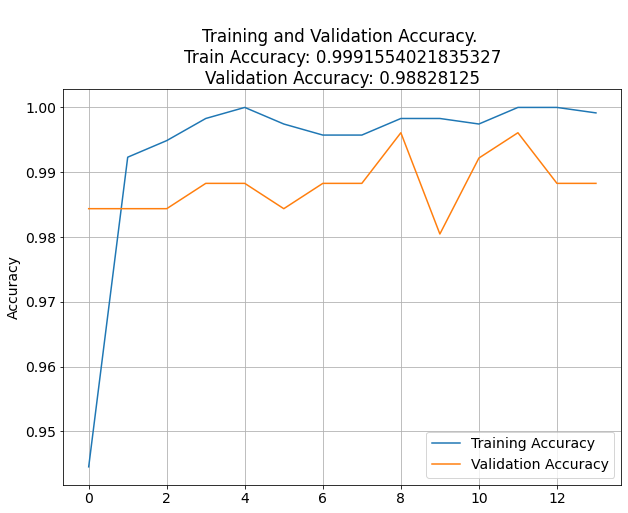

In [15]:
#Plot trianing curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
 
# plot results
# accuracy
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy: {str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}')

9/9 [==============================] - 3s 390ms/step
              precision    recall  f1-score   support

     cheetah       1.00      1.00      1.00        52
         fox       1.00      1.00      1.00        37
       hyena       1.00      1.00      1.00        46
        lion       1.00      1.00      1.00        44
       tiger       1.00      1.00      1.00        40
        wolf       1.00      1.00      1.00        39

    accuracy                           1.00       258
   macro avg       1.00      1.00      1.00       258
weighted avg       1.00      1.00      1.00       258



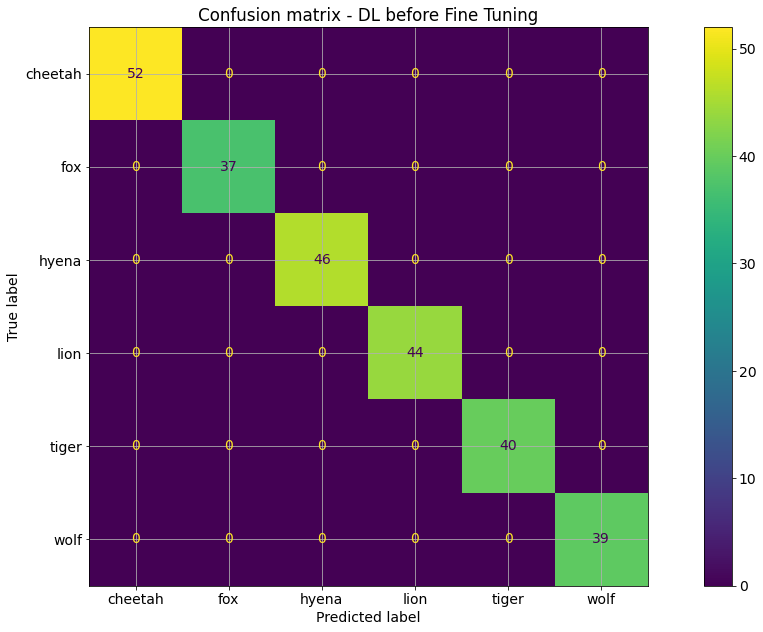

In [26]:
# plot classification report and confusion matrix before fine tuning DL model
test_labels = []

for i in range(0,int(9)):
    test_labels.extend(np.array(test_generator[i][1]))
test_labels = np.argmax(test_labels, axis=1)
y_pred = history.model.predict(test_generator)
y_pred=np.argmax(y_pred,axis=1)
# Get classification report and Confusion matrix for CNN-transfer learning before finetuning
from sklearn.metrics import ConfusionMatrixDisplay

target_names = ['cheetah','fox','hyena','lion','tiger','wolf']
print(classification_report(test_labels, y_pred, target_names=target_names))
cm = confusion_matrix(test_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=target_names)
disp.plot()
plt.title('Confusion matrix - DL before Fine Tuning')

plt.tight_layout()
plt.show()

In [17]:
# fine Tuning the pretrained model by unfreezing top layers of the base model
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))


Number of layers in the base model:  780


In [18]:
# unfreeze all layers
base_model.trainable = True
# Fine-tune from this layer onwards
fine_tune_at = 740

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [19]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),loss='categorical_crossentropy',metrics=['accuracy'])

In [20]:
# check the model with unfrozen top 50 layers 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 9, 9, 1536)       54336736  
 onal)                                                           
                                                                 
 batch_normalization_203 (Ba  (None, 9, 9, 1536)       10752     
 tchNormalization)                                               
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               786944    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                        

In [21]:
len(model.trainable_variables)

34

In [22]:
# Perform fine-tune model training
fine_tune_epochs = 10
initial_epochs = history.epoch[-1]
total_epochs = initial_epochs+fine_tune_epochs
batch_size=32
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size

history_fine = model.fit(train_generator,
                        steps_per_epoch=STEP_SIZE_TRAIN,
                        validation_data=validation_generator,
                        validation_steps=STEP_SIZE_VALID,
                        epochs=total_epochs,
                        callbacks=[early],
                        initial_epoch=history.epoch[-1])

Epoch 14/23
37/37 [==============================] - 37s 677ms/step - loss: 0.1532 - accuracy: 0.9770 - val_loss: 0.1306 - val_accuracy: 0.9922
Epoch 15/23
37/37 [==============================] - 21s 557ms/step - loss: 0.0029 - accuracy: 0.9983 - val_loss: 0.1197 - val_accuracy: 0.9922
Epoch 16/23
37/37 [==============================] - 21s 557ms/step - loss: 4.0087e-04 - accuracy: 1.0000 - val_loss: 0.1397 - val_accuracy: 0.9922
Epoch 17/23
37/37 [==============================] - 20s 538ms/step - loss: 0.0042 - accuracy: 0.9983 - val_loss: 0.1352 - val_accuracy: 0.9883
Epoch 18/23
37/37 [==============================] - 23s 633ms/step - loss: 8.1856e-04 - accuracy: 0.9991 - val_loss: 0.1293 - val_accuracy: 0.9922
Epoch 19/23
37/37 [==============================] - 22s 579ms/step - loss: 7.4756e-05 - accuracy: 1.0000 - val_loss: 0.1081 - val_accuracy: 0.9922
Epoch 20/23
37/37 [==============================] - 20s 551ms/step - loss: 1.3434e-05 - accuracy: 1.0000 - val_loss: 0.1056

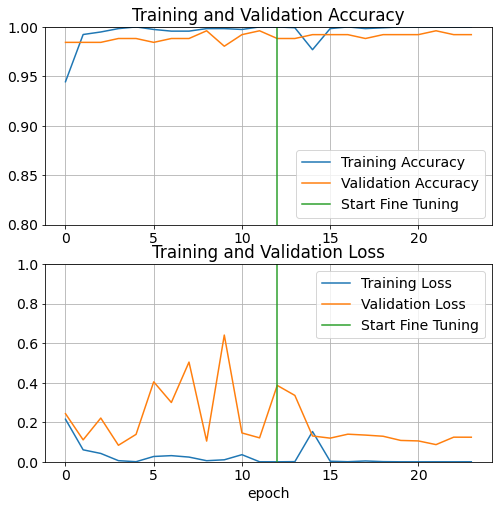

In [23]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

# plot fine Tuning results
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [24]:
# perfrom test predictions on fine tuned model
loss, accuracy = history_fine.model.evaluate(test_generator)
print('Test accuracy on fine tuned model :', accuracy)



9/9 [==============================] - 4s 393ms/step - loss: 2.7291e-06 - accuracy: 1.0000
Test accuracy on fine tuned model : 1.0


9/9 [==============================] - 7s 393ms/step
              precision    recall  f1-score   support

     cheetah       1.00      1.00      1.00        52
         fox       1.00      1.00      1.00        37
       hyena       1.00      1.00      1.00        46
        lion       1.00      0.98      0.99        44
       tiger       0.98      1.00      0.99        40
        wolf       1.00      1.00      1.00        39

    accuracy                           1.00       258
   macro avg       1.00      1.00      1.00       258
weighted avg       1.00      1.00      1.00       258



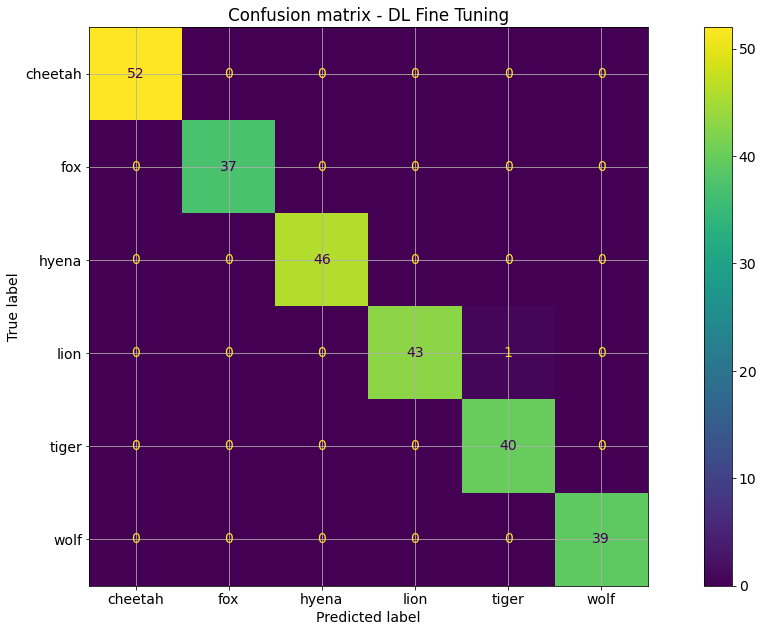

In [25]:
test_labels = []

for i in range(0,int(9)):
    test_labels.extend(np.array(test_generator[i][1]))
test_labels = np.argmax(test_labels, axis=1)
y_pred = history_fine.model.predict(test_generator)
y_pred=np.argmax(y_pred,axis=1)
# Get classification report and Confusion matrix for CNN-transfer learning after finetuning
from sklearn.metrics import ConfusionMatrixDisplay

target_names = ['cheetah','fox','hyena','lion','tiger','wolf']
print(classification_report(test_labels, y_pred, target_names=target_names))
cm = confusion_matrix(test_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=target_names)
disp.plot()
plt.title('Confusion matrix - DL Fine Tuning')

plt.tight_layout()
plt.show()